In [1]:
! kaggle datasets download sid321axn/amazon-alexa-reviews && ! unzip amazon-alexa-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews
License(s): other
  0% 0.00/164k [00:00<?, ?B/s]
100% 164k/164k [00:00<00:00, 56.8MB/s]
Archive:  amazon-alexa-reviews.zip
  inflating: amazon_alexa.tsv        


# Importação de bibliotecas e base de dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/amazon_alexa.tsv', sep = '\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.shape

(3150, 5)

# Exploração dos Dados

In [5]:
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [6]:
df[df['verified_reviews'] == df['verified_reviews'].isnull()]

,rating,date,variation,verified_reviews,feedback


In [7]:
df['verified_reviews'] = df['verified_reviews'].fillna('')

In [8]:
df['length'] = df['verified_reviews'].astype(str).apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


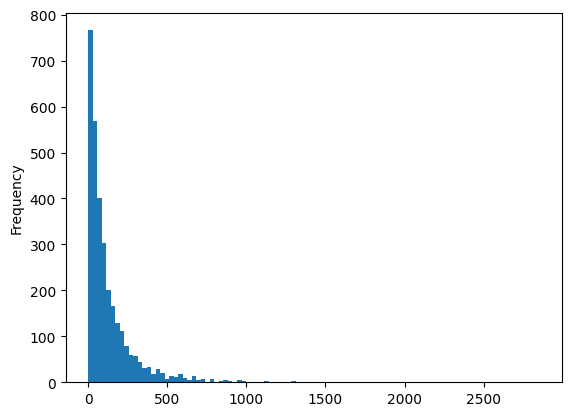

In [9]:
df['length'].plot(bins = 100, kind = 'hist');

In [10]:
positivos = df[df['feedback'] == 1]
negativos = df[df['feedback'] == 0]

In [11]:
positivos.describe()

,rating,feedback,length
count,2893.000000,2893.0,2893.000000
mean,4.737643,1.0,124.659177
std,0.546544,0.0,174.624491
min,3.000000,1.0,1.000000
25%,5.000000,1.0,29.000000
50%,5.000000,1.0,69.000000
75%,5.000000,1.0,154.000000
max,5.000000,1.0,2851.000000


In [12]:
negativos.describe()

,rating,feedback,length
count,257.000000,257.0,257.000000
mean,1.373541,0.0,215.225681
std,0.484688,0.0,236.340053
min,1.000000,0.0,0.000000
25%,1.000000,0.0,53.000000
50%,1.000000,0.0,137.000000
75%,2.000000,0.0,289.000000
max,2.000000,0.0,1686.000000


Pessoas insatisfeitas, em média, escrevem mais

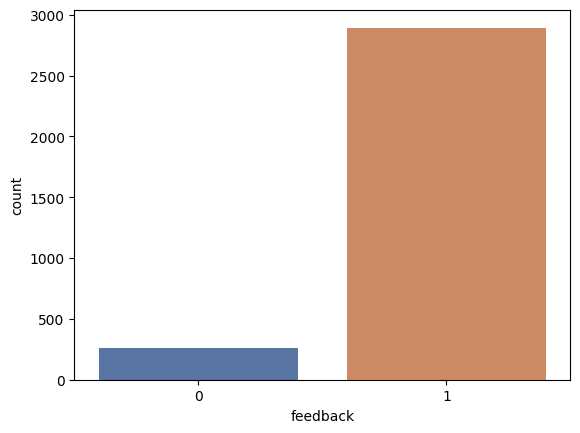

In [13]:
sns.countplot(x = 'feedback', data = df, palette='deep');

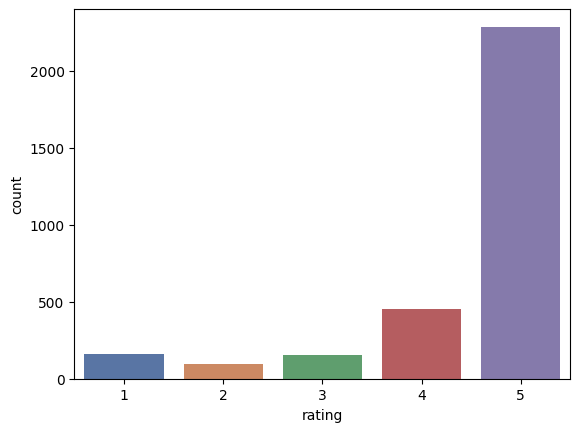

In [14]:
sns.countplot(x = 'rating', data = df, palette='deep');

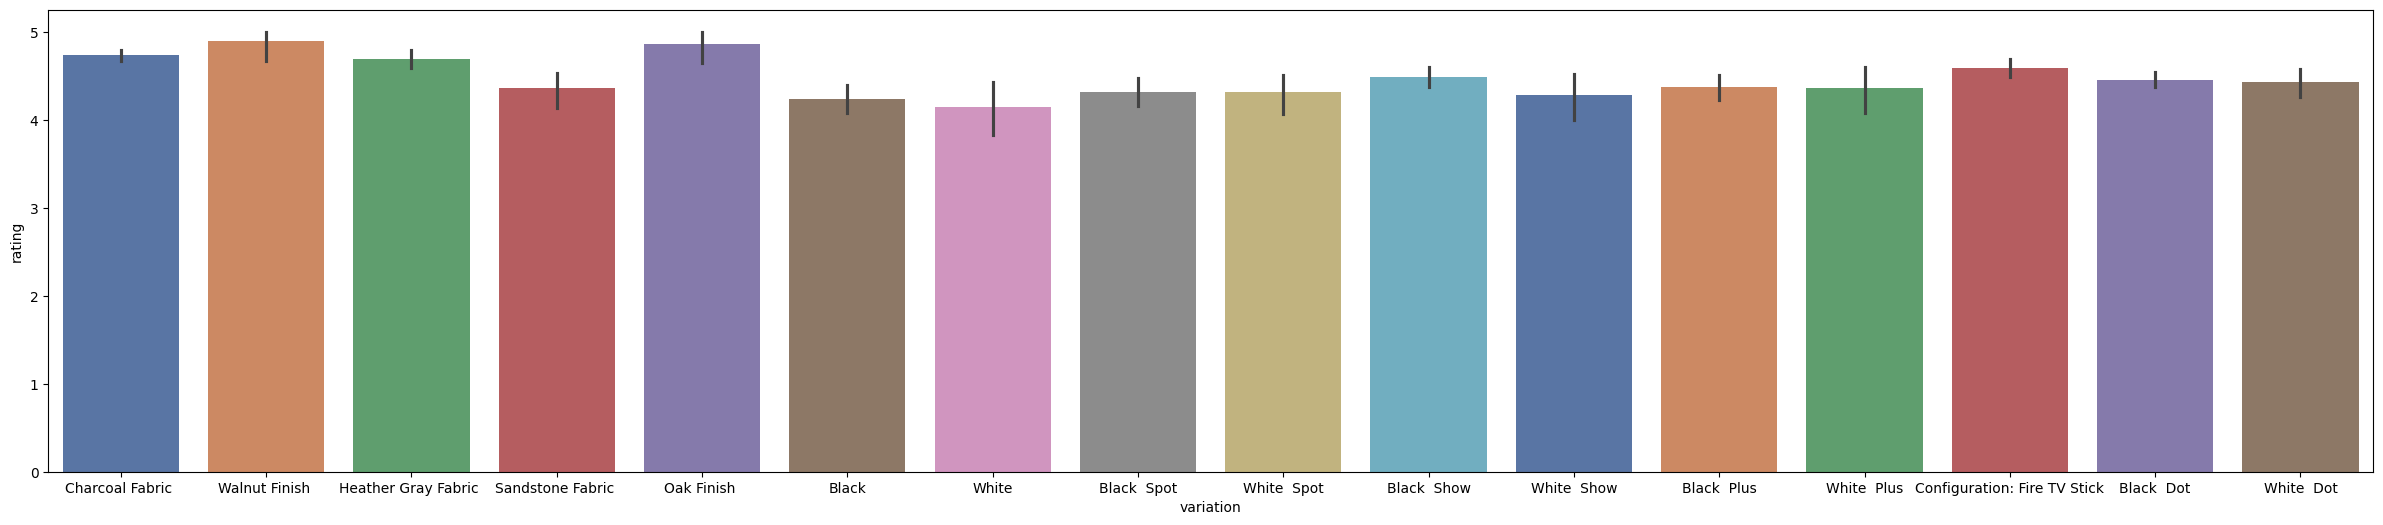

In [15]:
plt.figure(figsize=(30,6))
sns.barplot(x = 'variation', y = 'rating', data = df, palette='deep');

In [16]:
sentences = df['verified_reviews'].tolist()

In [17]:
uma_string = ' '.join([str(item) for item in sentences])

(-0.5, 399.5, 199.5, -0.5)

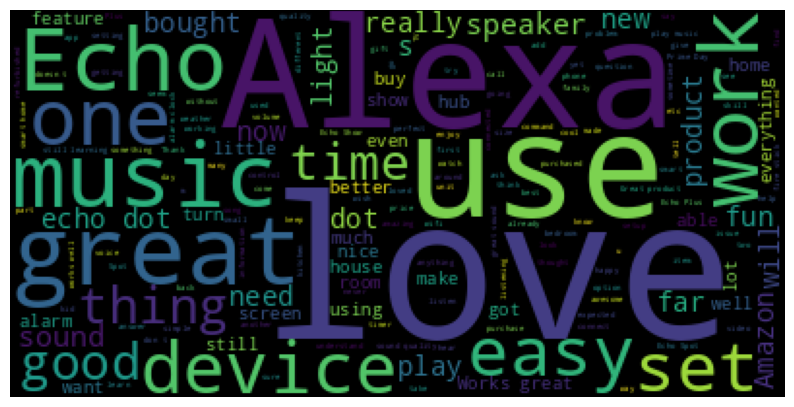

In [18]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(uma_string)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')

In [19]:
negativos_lista = negativos['verified_reviews'].tolist()
negativos_string = ' '.join([str(item) for item in negativos_lista])
len(negativos_string)

55569

(-0.5, 399.5, 199.5, -0.5)

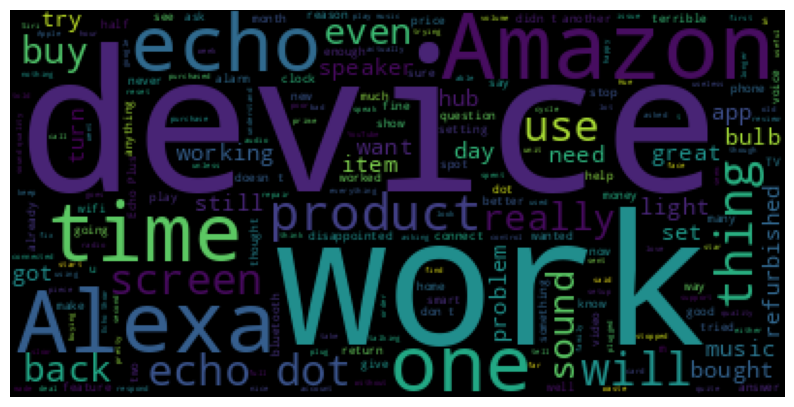

In [20]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(negativos_string)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')

# Limpeza e pré-processamento

In [21]:
def preprocessar_dados(df):
    """
    Realiza a limpeza e pré-processamento dos dados para análise de sentimentos.

    Etapas:
    1. Remove colunas desnecessárias ('date', 'rating', 'length').
    2. Aplica One-Hot Encoding na coluna 'variation'.
    3. Limpa e vetorializa a coluna 'verified_reviews' removendo pontuação e stopwords.
    4. Separa as variáveis preditoras (X) e a variável alvo (y), onde 'feedback' é a variável alvo.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados brutos.

    Retorno:
    tuple: X (pd.DataFrame) com variáveis preditoras processadas e y (pd.Series) com a variável alvo.
    """
    # Remover colunas desnecessárias
    df = df.drop(columns=['date', 'rating', 'length'], axis=1)

    # Aplicar One-Hot Encoding na coluna 'variation'
    ohe = OneHotEncoder()
    variation_encoded = ohe.fit_transform(df[['variation']]).toarray()
    df.drop('variation', axis=1, inplace=True)
    df = pd.concat([df, pd.DataFrame(variation_encoded)], axis=1)

    # Baixar stopwords do nltk se necessário
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    # Função para limpar texto
    def limpar_texto(texto):
        texto = str(texto)
        texto = ''.join([char for char in texto if char not in string.punctuation])
        texto = ' '.join([palavra.lower() for palavra in texto.split() if palavra.lower() not in stop_words])
        return texto

    # Aplicar limpeza
    df['verified_reviews'] = df['verified_reviews'].apply(limpar_texto)

    # Vetorização com CountVectorizer
    cv = CountVectorizer()
    reviews_vectorizado = cv.fit_transform(df['verified_reviews'])
    df.drop('verified_reviews', axis=1, inplace=True)
    df = pd.concat([df, pd.DataFrame(reviews_vectorizado.toarray())], axis=1)

    # Separar variáveis preditoras e variável alvo
    X = df.drop('feedback', axis=1)
    y = df['feedback']

    with open('pre.pkl', 'wb') as arquivo:
        pickle.dump([ohe, cv], arquivo)

    return X, y

In [22]:
X, y = preprocessar_dados(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Implementação de algoritmo Naive Bayes

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.36      0.48        64
           1       0.95      0.99      0.97       724

    accuracy                           0.94       788
   macro avg       0.83      0.67      0.72       788
weighted avg       0.93      0.94      0.93       788



# Implementação de algoritmo Regressão Logística

In [26]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [27]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.33      0.47        64
           1       0.94      0.99      0.97       724

    accuracy                           0.94       788
   macro avg       0.88      0.66      0.72       788
weighted avg       0.93      0.94      0.93       788



Métrica de avaliação é o F1-Score

# Classificação de uma frase

In [28]:
with open('model.pkl', 'wb') as arquivo:
    pickle.dump(lr, arquivo)

In [29]:
with open('model.pkl', 'rb') as arquivo:
    lr = pickle.load(arquivo)

In [30]:
def capturar_feedback():
    """
    Captura entrada do usuário para 'variation' e 'verified_reviews'.
    Retorna um DataFrame tratado pronto para previsão.
    """

    stop_words = set(stopwords.words('english'))

    variation = input("Qual seu produto? ")
    review = input("Digite a avaliação do produto: ")

    dados = pd.DataFrame({
        'variation': [variation],
        'verified_reviews': [review]
    })
    with open('pre.pkl', 'rb') as arquivo:
        ohe, cv = pickle.load(arquivo)

    variation_encoded = ohe.transform(dados[['variation']]).toarray()
    dados.drop('variation', axis=1, inplace=True)
    dados = pd.concat([dados, pd.DataFrame(variation_encoded)], axis=1)

    def limpar_texto(texto):
        texto = str(texto)
        texto = ''.join([char for char in texto if char not in string.punctuation])
        texto = ' '.join([palavra.lower() for palavra in texto.split() if palavra.lower() not in stop_words])
        return texto

    dados['verified_reviews'] = dados['verified_reviews'].apply(limpar_texto)

    reviews_vectorizado = cv.transform(dados['verified_reviews'])
    dados.drop('verified_reviews', axis=1, inplace=True)
    dados = pd.concat([dados, pd.DataFrame(reviews_vectorizado.toarray())], axis=1)

    return dados

In [31]:
negativos.iloc[0][['variation', 'verified_reviews']].values

array(['Charcoal Fabric ',
       "It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals."],
      dtype=object)

In [32]:
dados = capturar_feedback()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Qual seu produto? Charcoal Fabric 
Digite a avaliação do produto: It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals.


In [33]:
lr.predict(dados)

array([0])

Previu certo o feedback negativo